### Proyecto Final Grupal HENRY

**ML_1_Forecast_Train**  
Prueba de algoritmos de Forecast

**Autores:**

**Caminos Federico**  
**Londero Walter**  
**Pizarro Hernan**  
**Urteaga Facundo**  
**Veron Cintia**   

**Resumen:** Con el propósito de poder obtener información predictiva de la reputación de diferentes locales, se propone implementar algoritmos de forecasting. En primera instancia, se realiza un pequeño EDA de las reseñas para poder entender la naturaleza de la base de datos. Luego, se dividen los locales segun la cantidad de reseñas mensuales para implementar algoritmos adecuados segun la cantidad de datos disponibles. Por último, se definen los algoritmos e hiperparámetros con mejor desempeño para cada grupo de datos.

1.  **Carga de librerías y datos**
2.  **Análisis general de reseñas**
3.  **Prueba de forecasting para locales con pocas reseñas**
4.  **Prueba de forecasting para locales con reseñas moderadas**
5.  **Prueba de forecasting para locales con muchas reseñas**


#### 1. Carga de librerías y datos

In [36]:
# Carga de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product

In [37]:
# Cargar el archivo CSV en un DataFrame

df_locales = pd.read_csv("locales_LA.csv")
df_reviews = pd.read_csv("reviews_LA.csv")

In [38]:
df_reviews.head()

,user_id,time,rating,gmap_id,date,user_rating,weighted_rating,weight
0,1.089912e+20,1609909927056,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2021-01-06 05:12:07.056,1,5,1
1,1.112903e+20,1612849648663,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2021-02-09 05:47:28.663,1,5,1
2,1.126404e+20,1583643882296,4,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2020-03-08 05:04:42.296,3,12,3
3,1.174403e+20,1551938216355,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2019-03-07 05:56:56.355,3,15,3
4,1.005808e+20,1494910901933,5,0x80c2c778e3b73d33:0xbdc58662a4a97d49,2017-05-16 05:01:41.933,1,5,1


#### 2. Análisis general de reseñas

In [39]:
df_reviews["gmap_id"].nunique() # 767 locales para analizar

767

In [40]:
# Para realizar un forecast correcto, debemos manejar los mismos intervalos de tiempo.
# Para esto, agrupamos las reviews en promedios mensuales para cada local.

# Asegurarse de que las fechas están en el formato correcto
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

# Agrupar por gmap_id y mes, y calcular el promedio mensual
df_reviews['month'] = df_reviews['date'].dt.to_period('M')
monthly_reviews = df_reviews.groupby(['gmap_id', 'month']).agg({'rating': 'mean'}).reset_index()

# Contar la cantidad de ocurrencias de cada gmap_id
gmap_counts = monthly_reviews.groupby('gmap_id').size().reset_index(name='counts')

# Mostrar el resultado
# print(gmap_counts)

In [41]:
monthly_reviews.head() # Dataframe que agrupa las reviews en valores mensuales

,gmap_id,month,rating
0,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,2016-10,5.0
1,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,2016-12,5.0
2,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,2017-07,1.0
3,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,2017-08,5.0
4,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,2017-09,5.0


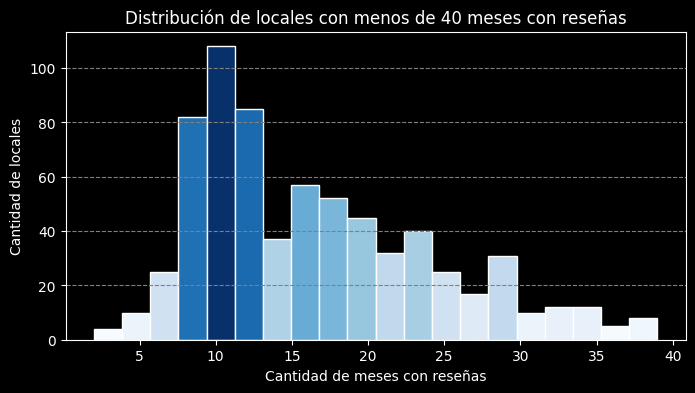

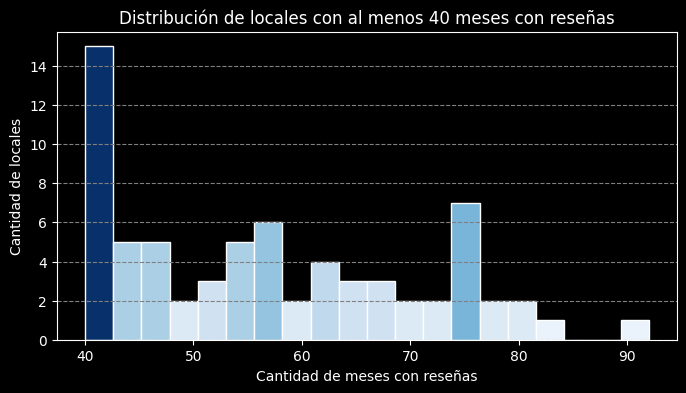

In [42]:
# Filtrar los counts
gmap_counts_less_40 = gmap_counts[gmap_counts['counts'] < 40]
gmap_counts_more_40 = gmap_counts[gmap_counts['counts'] >= 40]

# Crear el primer histograma para counts < 40
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 4))

counts, bins, patches = ax.hist(gmap_counts_less_40['counts'], bins=20, edgecolor='white')
norm = plt.Normalize(counts.min(), counts.max())
cmap = plt.cm.get_cmap('Blues')

for count, patch in zip(counts, patches):
    color = cmap(norm(count))
    patch.set_facecolor(color)

ax.set_xlabel('Cantidad de meses con reseñas', color='white')
ax.set_ylabel('Cantidad de locales', color='white')
ax.set_title('Distribución de locales con menos de 40 meses con reseñas', color='white')
ax.grid(axis='y', linestyle='--', color='gray')

# Cambiar color de los ticks y labels
ax.tick_params(colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Mostrar el primer histograma
plt.show()

# Crear el segundo histograma para counts > 40
fig, ax = plt.subplots(figsize=(8, 4))

counts, bins, patches = ax.hist(gmap_counts_more_40['counts'], bins=20, edgecolor='white')
norm = plt.Normalize(counts.min(), counts.max())
cmap = plt.cm.get_cmap('Blues')

for count, patch in zip(counts, patches):
    color = cmap(norm(count))
    patch.set_facecolor(color)

ax.set_xlabel('Cantidad de meses con reseñas', color='white')
ax.set_ylabel('Cantidad de locales', color='white')
ax.set_title('Distribución de locales con al menos 40 meses con reseñas', color='white')
ax.grid(axis='y', linestyle='--', color='gray')

# Cambiar color de los ticks y labels
ax.tick_params(colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Mostrar el segundo histograma
plt.show()


#### 2. Prueba de forecasting para locales con pocas reseñas (Hasta 15 meses con reseñas)

In [43]:
# Filtro los locales con menos de 16 reviews mensuales

gmap_pocos = gmap_counts[gmap_counts['counts'] < 16]
gmap_pocos.head()

,gmap_id,counts
4,0x80c2b09b6710f02d:0xf58ccff2da1c8d08,10
8,0x80c2b0d7f6cd76c3:0xc78eb0bd84f97a66,15
9,0x80c2b0d7f9ffc3a5:0x4d9a5ee497d13132,12
11,0x80c2b126e58bd95b:0xec75330a286f453,11
12,0x80c2b129730002ff:0xfb010630928888ca,8


In [44]:
# Elijo evaluar algoritmos sencillos debido a la baja cantidad de reviews. Evaluo SimpleExpSmoothing, Holt y ExponentialSmoothing

# Lista para almacenar los resultados
resultados_pocas = []

# Definir los valores de alpha a probar
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Iterar sobre cada gmap_id en gmap_pocos
for gmap_id in gmap_pocos['gmap_id']:
    # Filtrar las reviews correspondientes de monthly_reviews
    df = monthly_reviews[monthly_reviews['gmap_id'] == gmap_id].set_index('month')['rating']
    
    # Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    if len(train) < 3 or len(test) < 1:
        print(f"No hay suficiente información para el gmap_id {gmap_id}")
        continue
    
    # Evaluar diferentes modelos y almacenar resultados
    for alpha in alpha_values:
        try:
            # Ajustar el modelo SimpleExpSmoothing con diferentes valores de alpha
            model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
            test_forecast = model.forecast(steps=len(test))
            
            # Aplicar límite a las predicciones entre 1 y 5
            test_forecast = np.clip(test_forecast, 1, 5)
            
            mae = mean_absolute_error(test, test_forecast)
            rmse = np.sqrt(mean_squared_error(test, test_forecast))
            mape = mean_absolute_percentage_error(test, test_forecast)
            
            resultados_pocas.append({
                'gmap_id': gmap_id,
                'model': 'SimpleExpSmoothing',
                'alpha': alpha,
                'rmse': rmse,
                'mae': mae,
                'mape': mape
            })
        except:
            print(f"Error fitting SimpleExpSmoothing model with alpha {alpha} for gmap_id {gmap_id}")
            continue
    
    # Ajustar el modelo Holt
    try:
        model = Holt(train).fit(optimized=True)
        test_forecast = model.forecast(steps=len(test))
        
        # Aplicar límite a las predicciones entre 1 y 5
        test_forecast = np.clip(test_forecast, 1, 5)
        
        mae = mean_absolute_error(test, test_forecast)
        rmse = np.sqrt(mean_squared_error(test, test_forecast))
        mape = mean_absolute_percentage_error(test, test_forecast)
        
        resultados_pocas.append({
            'gmap_id': gmap_id,
            'model': 'Holt',
            'alpha': None,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        })
    except:
        print(f"Error fitting Holt model for gmap_id {gmap_id}")
        continue
    
    # Ajustar el modelo ExponentialSmoothing
    try:
        model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(optimized=True)
        test_forecast = model.forecast(steps=len(test))
        
        # Aplicar límite a las predicciones entre 1 y 5
        test_forecast = np.clip(test_forecast, 1, 5)
        
        mae = mean_absolute_error(test, test_forecast)
        rmse = np.sqrt(mean_squared_error(test, test_forecast))
        mape = mean_absolute_percentage_error(test, test_forecast)
        
        resultados_pocas.append({
            'gmap_id': gmap_id,
            'model': 'ExponentialSmoothing',
            'alpha': None,
            'rmse': rmse,
            'mae': mae,
            'mape': mape
        })
    except:
        print(f"Error fitting ExponentialSmoothing model for gmap_id {gmap_id}")
        continue

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(resultados_pocas)

# Evaluar el desempeño global del algoritmo
global_mae = results_df.groupby('model')['mae'].mean()
global_rmse = results_df.groupby('model')['rmse'].mean()
global_mape = results_df.groupby('model')['mape'].mean()

print("Desempeño Global:")
print(f"MAE por modelo: \n{global_mae}")
print(f"RMSE por modelo: \n{global_rmse}")
print(f"MAPE por modelo: \n{global_mape}")

# Evaluar el mejor alpha para SimpleExpSmoothing
simple_exp_results = results_df[results_df['model'] == 'SimpleExpSmoothing']
best_alpha_mae = simple_exp_results.loc[simple_exp_results['mae'].idxmin()]['alpha']
best_alpha_rmse = simple_exp_results.loc[simple_exp_results['rmse'].idxmin()]['alpha']
best_alpha_mape = simple_exp_results.loc[simple_exp_results['mape'].idxmin()]['alpha']

print(f"Mejor alpha por MAE para SimpleExpSmoothing: {best_alpha_mae}")
print(f"Mejor alpha por RMSE para SimpleExpSmoothing: {best_alpha_rmse}")
print(f"Mejor alpha por MAPE para SimpleExpSmoothing: {best_alpha_mape}")


No hay suficiente información para el gmap_id 0x80c2b7673a22acbb:0x86abbe840ad38703
No hay suficiente información para el gmap_id 0x80c2b923f9df207d:0x20daab49c5a6b9b9
No hay suficiente información para el gmap_id 0x80c2b9d00db246d9:0x796dc4a542d6f9b8
No hay suficiente información para el gmap_id 0x80c2c7a55b28dcf1:0x17dc8000c6fb0be6
Desempeño Global:
MAE por modelo: 
model
ExponentialSmoothing    1.311198
Holt                    1.266376
SimpleExpSmoothing      0.833933
Name: mae, dtype: float64
RMSE por modelo: 
model
ExponentialSmoothing    1.463463
Holt                    1.415365
SimpleExpSmoothing      0.953687
Name: rmse, dtype: float64
MAPE por modelo: 
model
ExponentialSmoothing    0.424237
Holt                    0.429909
SimpleExpSmoothing      0.345027
Name: mape, dtype: float64
Mejor alpha por MAE para SimpleExpSmoothing: 0.1
Mejor alpha por RMSE para SimpleExpSmoothing: 0.1
Mejor alpha por MAPE para SimpleExpSmoothing: 0.1


In [45]:
# ELECCIÓN:

# A partir de los resultados que arrojan los modelos, observamos que el Simple Exponential Smoothing tiene un mejor desempeño en RMSE, MAE y MAPE.
# A su vez, el mejor alpha para este algoritmo es el de 0.1

#### 4. Prueba de forecasting para locales con reseñas moderadas

In [14]:
# Filtrar los gmap_id con counts entre 16 y 30

gmap_moderadas = gmap_counts.loc[(gmap_counts['counts'] >= 16) & (gmap_counts['counts'] <= 30)]
gmap_moderadas.head()

,gmap_id,counts
0,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,24
1,0x80c29b3ff5888f5f:0xb054c9f681f3cdd1,19
5,0x80c2b0a1b0555783:0x54ead601f75040cc,24
6,0x80c2b0ad14d8dc71:0x7913d1b06444b033,20
7,0x80c2b0cd81852b8f:0x897e091f626c0c8b,16


Desempeño Global - MAE: 0.472165652926598, RMSE: 0.8789445177214313, MAPE: 0.22175582299184596


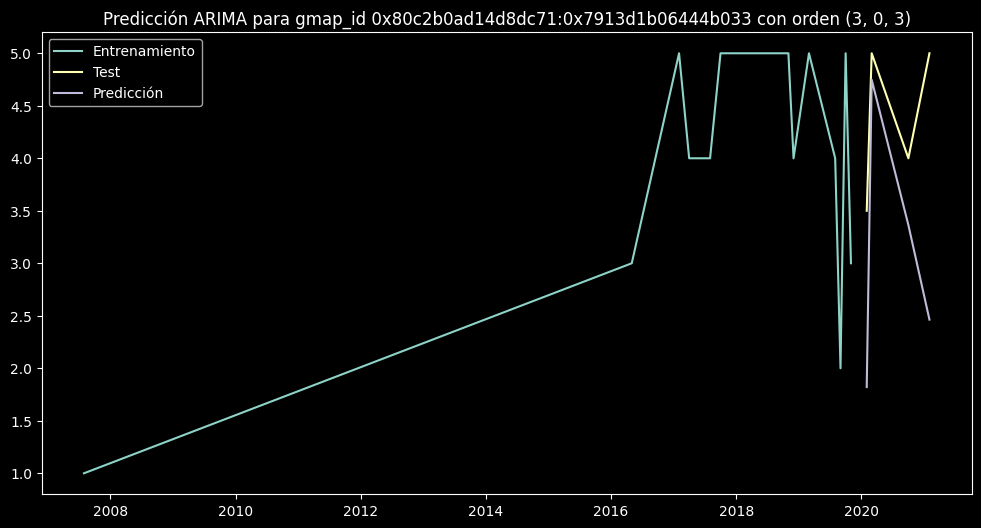

In [15]:
# Elijo evaluar un algoritmo mas complejo como ARIMA debido a la moderada cantidad de reviews

# Lista para almacenar los resultados
results = []

# Definir los valores de p, d, q a probar (Hiperparámetros)
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Iterar sobre cada gmap_id en gmap_moderadas
for gmap_id in gmap_moderadas['gmap_id']:
    # Filtrar las reviews correspondientes de monthly_reviews
    df = monthly_reviews[monthly_reviews['gmap_id'] == gmap_id].set_index('month')['rating']
    
    # Convertir el índice de Period a Timestamp
    #df.index = df.index.to_timestamp()
    
    # Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    if len(train) < 3 or len(test) < 1:
        print(f"Not enough data for gmap_id {gmap_id}")
        continue
    
    # Probar diferentes combinaciones de p, d, q
    best_mae, best_rmse, best_mape = np.inf, np.inf, np.inf
    best_order = None
    best_forecast = None
    
    for order in product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            
            # Realizar predicciones en el conjunto de prueba
            test_forecast = model_fit.forecast(steps=len(test))

            # Aplicar límite a las predicciones entre 1 y 5
            test_forecast = np.clip(test_forecast, 1, 5)
            
            # Evaluar el rendimiento del modelo
            mae = mean_absolute_error(test, test_forecast)
            rmse = np.sqrt(mean_squared_error(test, test_forecast))
            mape = mean_absolute_percentage_error(test, test_forecast)
            
            if mae < best_mae:
                best_mae, best_rmse, best_mape = mae, rmse, mape
                best_order = order
                best_forecast = test_forecast
            
        except:
            continue
    
    # Guardar los resultados
    if best_order:
        results.append({
            'gmap_id': gmap_id,
            'order': best_order,
            'last_three_ratings': train[-3:].tolist(),
            'predicted_three_ratings': best_forecast[:3].tolist(),
            'rmse': best_rmse,
            'mae': best_mae,
            'mape': best_mape
        })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Evaluar el desempeño global del algoritmo
global_mae = results_df['mae'].mean()
global_rmse = np.sqrt(np.mean(results_df['rmse']**2))
global_mape = results_df['mape'].mean()

print(f"Desempeño Global - MAE: {global_mae}, RMSE: {global_rmse}, MAPE: {global_mape}")

# Graficar uno de los gmap_id de ejemplo
example_gmap_id = results_df.iloc[3]['gmap_id']
example_df = monthly_reviews[monthly_reviews['gmap_id'] == example_gmap_id].set_index('month')['rating']
example_df.index = example_df.index.to_timestamp()

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(example_df) * 0.8)
train, test = example_df.iloc[:train_size], example_df.iloc[train_size:]

# Ajustar el modelo ARIMA con el mejor orden
best_order = results_df.iloc[0]['order']
model = ARIMA(train, order=best_order)
model_fit = model.fit()
test_forecast = model_fit.forecast(steps=len(test))

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, test_forecast, label='Predicción')
plt.legend()
plt.title(f'Predicción ARIMA para gmap_id {example_gmap_id} con orden {best_order}')
plt.show()

In [16]:
results_df.head()

,gmap_id,order,last_three_ratings,predicted_three_ratings,rmse,mae,mape
0,0x14e1b0df6d819dab:0x928b6349b7fbe2f4,"(3, 0, 3)","[5.0, 5.0, 5.0]","[5.0, 4.368077659607097, 4.160804207916471]",0.805385,0.474388,0.205360
1,0x80c29b3ff5888f5f:0xb054c9f681f3cdd1,"(5, 1, 3)","[5.0, 5.0, 5.0]","[4.115860181335918, 5.0, 4.8661887823257075]",0.352109,0.265973,0.070319
2,0x80c2b0a1b0555783:0x54ead601f75040cc,"(1, 2, 0)","[3.5, 5.0, 4.0]","[4.742757792353671, 4.270633695584402, 4.64540...",0.624725,0.465381,0.127272
3,0x80c2b0ad14d8dc71:0x7913d1b06444b033,"(2, 0, 2)","[2.0, 5.0, 3.0]","[2.972176864240211, 4.791506998963124, 3.92193...",0.454347,0.379940,0.088274
4,0x80c2b0cd81852b8f:0x897e091f626c0c8b,"(0, 0, 1)","[4.333333333333333, 5.0, 3.0]","[4.536671215065626, 4.266732915120312, 4.26673...",1.678167,1.067485,0.868343


In [17]:
results_df["order"].value_counts()

order
(0, 1, 0)    38
(5, 2, 0)     8
(1, 2, 0)     8
(0, 2, 0)     7
(5, 2, 5)     6
             ..
(1, 2, 1)     1
(3, 1, 3)     1
(5, 0, 1)     1
(1, 1, 4)     1
(4, 1, 3)     1
Name: count, Length: 89, dtype: int64

In [46]:
# ELECCIÓN:

# A partir de los resultados que arrojan los modelos, observamos que luego del modelo mas sencillo (0, 1, 0), el modelo predilecto es el (1, 2, 0)

#### 4. Prueba de forecasting para locales con muchas reseñas

In [47]:
gmap_muchos = gmap_counts[gmap_counts['counts'] > 30]
gmap_muchos.head()

,gmap_id,counts
2,0x80c2b094b4dba76b:0xa06e6ac61be494f1,31
3,0x80c2b09a1aa56c23:0x7f821110921eff5d,53
10,0x80c2b0ea7a7e0265:0x9d0ce9405491604f,72
19,0x80c2b62d0f38babb:0xbea67f4318669b8d,47
22,0x80c2b6da0dfff2e1:0xb529433611b431fd,64


In [48]:
# Elijo evaluar un algoritmo mas complejo como SARIMAX debido a la gran cantidad de reviews

# Definir los hiperparámetros a evaluar
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2]
seasonal_p = [0, 1]
seasonal_d = [0, 1]
seasonal_q = [0, 1]
seasonal_period = [12]  # Asumimos estacionalidad anual

# Crear todas las combinaciones de hiperparámetros
param_grid = list(product(p, d, q, seasonal_p, seasonal_d, seasonal_q))

# Lista para almacenar los resultados
all_results = []

# Iterar sobre cada combinación de hiperparámetros
for params in param_grid:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], seasonal_period[0])
    print(f"Evaluando combinación: order={order}, seasonal_order={seasonal_order}")

    # Lista para almacenar los resultados de cada gmap_id para la combinación actual
    results = []

    # Iterar sobre cada gmap_id en gmap_muchos
    for gmap_id in gmap_muchos['gmap_id']:
        # Filtrar las reviews correspondientes de monthly_reviews
        df = monthly_reviews[monthly_reviews['gmap_id'] == gmap_id][['month', 'rating']]
        
        # Convertir el índice de Period a Timestamp
        df['month'] = df['month'].dt.to_timestamp()
        
        # Renombrar columnas
        df.rename(columns={'month': 'ds', 'rating': 'y'}, inplace=True)
        
        # Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
        train_size = int(len(df) * 0.8)
        train, test = df.iloc[:train_size], df.iloc[train_size:]
        
        if len(train) < 3 or len(test) < 1:
            print(f"Not enough data for gmap_id {gmap_id}")
            continue
        
        # Ajustar el modelo SARIMAX con los hiperparámetros seleccionados
        try:
            model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            
            # Realizar predicciones en el conjunto de prueba
            forecast = model_fit.forecast(steps=len(test))
            
            # Evaluar el rendimiento del modelo
            mae = mean_absolute_error(test['y'], forecast)
            rmse = np.sqrt(mean_squared_error(test['y'], forecast))
            mape = mean_absolute_percentage_error(test['y'], forecast)
            
            # Guardar los resultados
            results.append({
                'gmap_id': gmap_id,
                'mae': mae,
                'rmse': rmse,
                'mape': mape
            })
            
        except Exception as e:
            print(f"Failed to fit SARIMAX model for gmap_id {gmap_id}: {e}")
    
    # Calcular métricas promedio para la combinación de hiperparámetros actual
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        avg_mae = results_df['mae'].mean()
        avg_rmse = np.sqrt(np.mean(results_df['rmse']**2))
        avg_mape = results_df['mape'].mean()
        
        # Guardar los resultados de la combinación de hiperparámetros
        all_results.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'avg_mae': avg_mae,
            'avg_rmse': avg_rmse,
            'avg_mape': avg_mape
        })

# Convertir los resultados a un DataFrame
all_results_df = pd.DataFrame(all_results)

Evaluando combinación: order=(0, 0, 0), seasonal_order=(0, 0, 0, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(0, 0, 1, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(0, 1, 0, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(0, 1, 1, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(1, 0, 0, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(1, 0, 1, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(1, 1, 0, 12)
Evaluando combinación: order=(0, 0, 0), seasonal_order=(1, 1, 1, 12)
Evaluando combinación: order=(0, 0, 1), seasonal_order=(0, 0, 0, 12)
Evaluando combinación: order=(0, 0, 1), seasonal_order=(0, 0, 1, 12)
Evaluando combinación: order=(0, 0, 1), seasonal_order=(0, 1, 0, 12)
Evaluando combinación: order=(0, 0, 1), seasonal_order=(0, 1, 1, 12)
Evaluando combinación: order=(0, 0, 1), seasonal_order=(1, 0, 0, 12)
Evaluando combinación: order=(0, 0, 1), seasonal_order=(1, 0, 1, 12)
Evaluando combinación: order=(0, 0

In [49]:
all_results_df = all_results_df.round(2)
# Obtener la fila con el menor avg_mae
min_avg_mae_row = all_results_df.loc[all_results_df['avg_rmse'].idxmin()]

# Ver el resultado
print(min_avg_mae_row)

order                 (1, 1, 2)
seasonal_order    (0, 0, 0, 12)
avg_mae                    0.66
avg_rmse                   0.93
avg_mape                   0.25
Name: 88, dtype: object


In [50]:
# ELECCIÓN:

# Se observa que los hiperparámetros con mejor desempeño son order (1, 1, 2) y seasonal_order (0, 0, 0, 12)

#### FIN